In [ ]:
import os
import glob
import numpy as np
import pandas as pd

import openslide
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt 

import sys
sys.path.append("/scratch_tmp/users/k21066795/NBT-Classifier")

from utils import *
from utils_vis import plot_oneline, get_JSON, show_roi, patch_overlay_wsi

### Load WSI & foreground tissue mask

In [2]:
wsi_pt = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/KHP_RM/17064108_FPE_1.ndpi'
mask_pt = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/QCs/KHP/17064108_FPE_1/17064108_FPE_1.ndpi_mask_use.png'

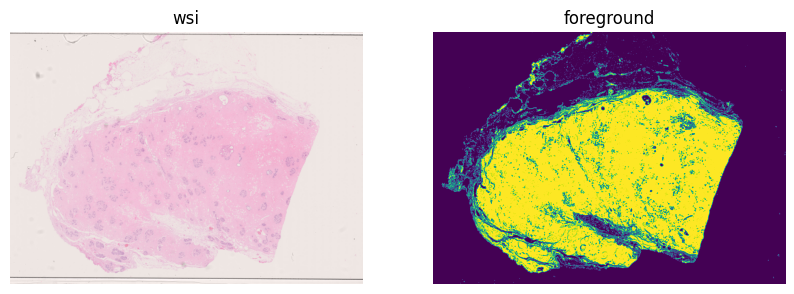

In [3]:
wsi = openslide.OpenSlide(wsi_pt)
im_wsi = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
im_mask = Image.open(mask_pt)
plot_oneline([im_wsi, im_mask], ['wsi', 'foreground'], (10,10))

### Whole slide tissue classification

In [ ]:
foreground_thes=0.7
patch_size_microns = 128
IMAGE_SIZE = (512, 512)
model_weights = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/CKPTs/TC_512px.h5'
model = get_TC(model_weights, image_size=IMAGE_SIZE, num_classes=3, output_features=False)

In [5]:
wsi_name = "17064108_FPE_1"
output_dir = os.path.join("/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/temp", wsi_name)
os.makedirs(output_dir, exist_ok=True)
TC_maskpt = os.path.join(output_dir, f"{wsi_name}_TCprobmask.npy")

patch_size, _ = parse_patch_size(wsi, patch_size_microns)
print(patch_size)
tissue_map = run_TC_one_slide(wsi, mask_pt, TC_maskpt, patch_size, foreground_thes, IMAGE_SIZE, model, free_space=False)

579


### Whole slide tissue class heatmaps

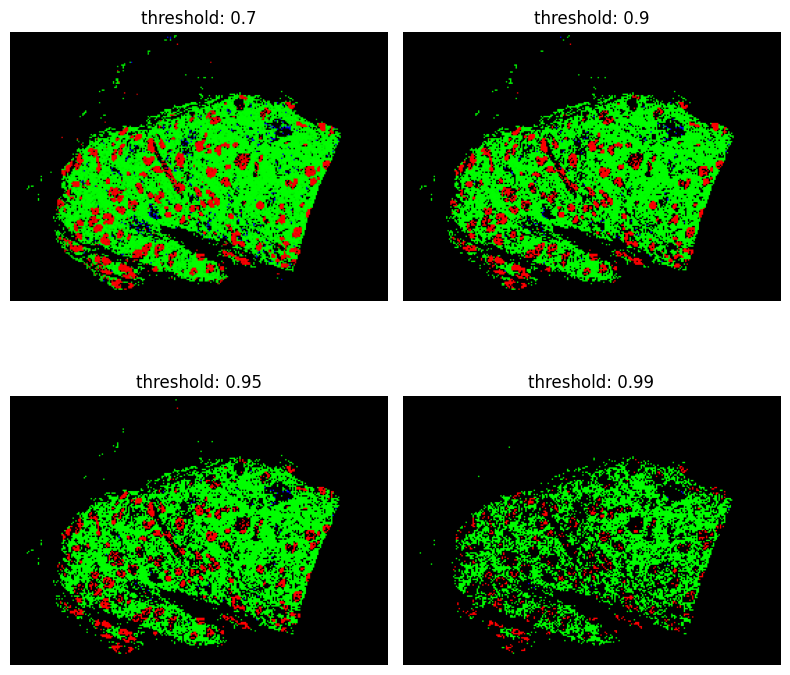

In [8]:
images = []
thresholds = [0.7, 0.9, 0.95, 0.99]
for threshold in thresholds:
    im = tissue_map.copy()
    im[:,:, 0][tissue_map[:,:, 0] < threshold] = 0
    im[:,:, 1][tissue_map[:,:, 1] < threshold] = 0
    im[:,:, 2][tissue_map[:,:, 2] < threshold] = 0
    images.append(im)


fig, axs = plt.subplots(2, 2, figsize=(8, 8))
counter = 0
for x in range(2):
    for y in range(2):
        axs[x, y].imshow(images[counter])
        axs[x, y].set_title(f'threshold: {thresholds[counter]}')
        axs[x, y].axis('off') 
        counter += 1
plt.tight_layout()
plt.show()

In [9]:
save_Allpatch(tissue_map, patch_size, output_dir) 
cls_dict = {'epithelium': 0, 'stroma':1, 'adipocytes':2, 'background': 3}
patch_csv = f"{output_dir}/{wsi_name}_All.csv"
json_pt = f"{output_dir}/{wsi_name}_TC512.json"
cls_df = pd.read_csv(patch_csv)

# Converting to JSON Format for QuPath Compatibility
get_JSON(cls_df, json_pt, patch_size, require_bounds=False)
cls_df.head()

/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/temp/17064108_FPE_1/17064108_FPE_1_All.csv saved!
/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/temp/17064108_FPE_1/17064108_FPE_1_TC512.json saved!


,patch_id,grid_x,grid_y,orig_x,orig_y,TC_epi,TC_str,TC_adi,cls,cohort,wsi_id
0,17064108_FPE_1_0_0_579,0,0,0,0,0.0,0.0,0.0,0,temp,17064108_FPE_1
1,17064108_FPE_1_0_1_579,0,1,0,579,0.0,0.0,0.0,0,temp,17064108_FPE_1
2,17064108_FPE_1_0_2_579,0,2,0,1158,0.0,0.0,0.0,0,temp,17064108_FPE_1
3,17064108_FPE_1_0_3_579,0,3,0,1737,0.0,0.0,0.0,0,temp,17064108_FPE_1
4,17064108_FPE_1_0_4_579,0,4,0,2316,0.0,0.0,0.0,0,temp,17064108_FPE_1


## Lobule binary mask

/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/temp/17064108_FPE_1/17064108_FPE_1_epi_(18,0,0,8704,6208)-mask.png saved!


(-0.5, 8703.5, 6207.5, -0.5)

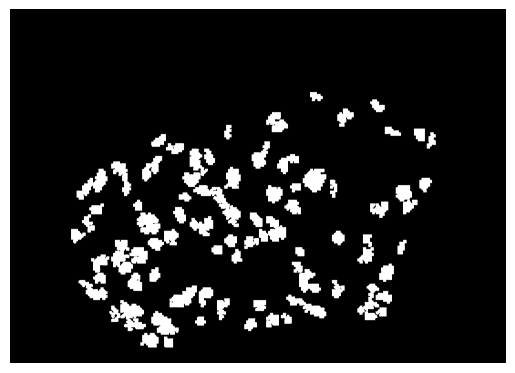

In [10]:
upscale_factor = 32
small_objects=400000
roi_width = 250

epi_mask, roi_width, wsi_mask_ratio = process_TCmask(wsi, tissue_map, upscale_factor, small_objects, roi_width)
save_epi_mask(epi_mask, wsi_mask_ratio, output_dir)
plt.imshow(epi_mask, cmap = 'gray')
plt.axis("off")

## ROI detection 

Saved /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/temp/17064108_FPE_1/17064108_FPE_1_bbx.png!


(-0.5, 8703.5, 6207.5, -0.5)

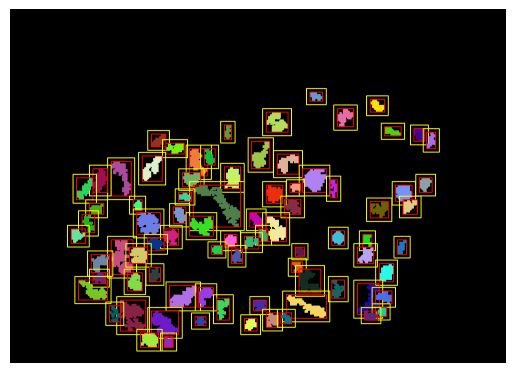

In [11]:
overlay_path = f"{output_dir}/{wsi_name}_bbx.png"
bbx_map = bbx_overlay(epi_mask, overlay_path, roi_width)

plt.imshow(bbx_map)
plt.axis('off')

There're 81 ROIs detected


(-0.5, 9184.5, 8604.5, -0.5)

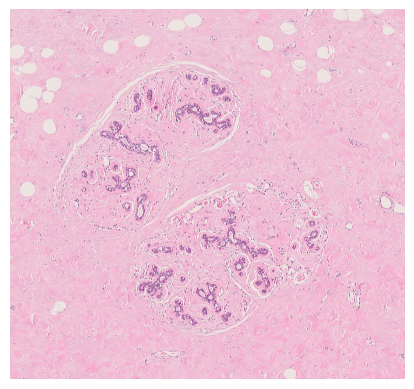

In [11]:
wsi_id = "17064108_FPE_1"
# get roi ids for all ROIs detected on the WSI
roi_ids = get_roi_ids(epi_mask, wsi_id, roi_width, wsi_mask_ratio)

## display a single ROI
im = show_roi(wsi, roi_ids[3])
plt.imshow(im)
plt.axis('off')

In [12]:
json_pt = f"{output_dir}/{wsi_name}_TC512_ROIdetection.json"
patch_df = save_ROIpatch(tissue_map, epi_mask, wsi_mask_ratio, roi_width, patch_size, output_dir)

# Converting to JSON Format for QuPath Compatibility
get_JSON(patch_df, json_pt, patch_size, require_bounds=False)
patch_df.head()

There're 81 ROIs detected
Saved /scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/temp/17064108_FPE_1/17064108_FPE_1_patch.csv!
/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/temp/17064108_FPE_1/17064108_FPE_1_TC512_ROIdetection.json saved!


,roi_id,patch_id,cls,TC_epi,TC_str,TC_adi,cohort,wsi_id,orig_x,orig_y
0,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_165_46_579,1,0.962390,0.037592,0.000017,temp,17064108_FPE_1,95535,26634
1,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_166_46_579,1,0.875104,0.124797,0.000100,temp,17064108_FPE_1,96114,26634
2,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_167_46_579,1,0.990265,0.009713,0.000022,temp,17064108_FPE_1,96693,26634
3,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_165_47_579,1,0.965307,0.034632,0.000061,temp,17064108_FPE_1,95535,27213
4,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_166_47_579,1,0.945866,0.053918,0.000216,temp,17064108_FPE_1,96114,27213


## Targeted patch selection

Total samples: 3120
Unique classes in sampled data: [1 2 3]


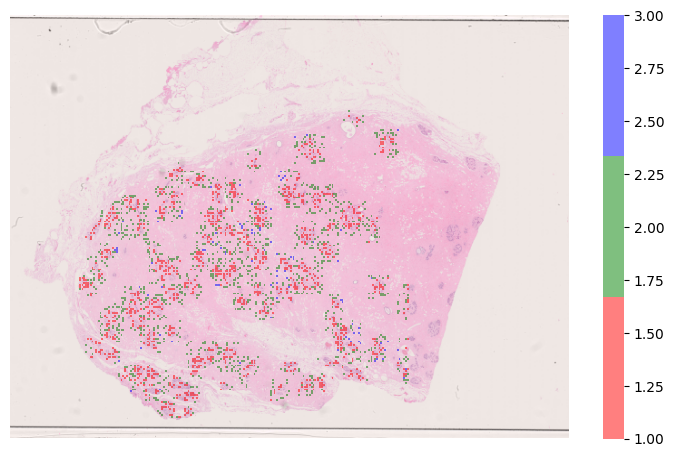

In [13]:
num2sample = 1500
sampled_patches = []
for cls in [1, 2, 3]:
    df_cls = patch_df[patch_df["cls"] == cls]
    df_cls_shuffled = df_cls.sample(frac=1, random_state=42)
    df_cls_sampled = df_cls_shuffled.head(num2sample)
    sampled_patches.append(df_cls_sampled)

patch_sampled = pd.concat(sampled_patches, ignore_index=True)
print(f"Total samples: {len(patch_sampled)}")
print(f"Unique classes in sampled data: {np.unique(patch_sampled['cls'])}")

fig = patch_overlay_wsi(patch_sampled, wsi_pt, patch_size, figsize=(9, 5.5))

### Alternatively, using TC_1024

(-0.5, 135.5, 96.5, -0.5)

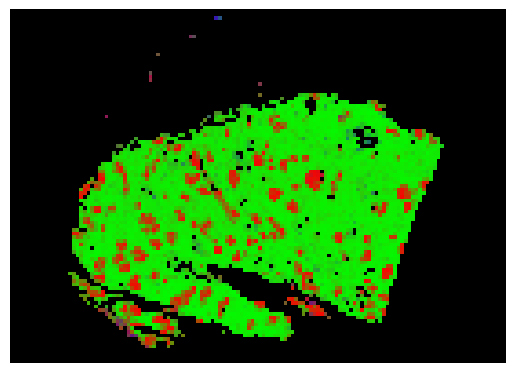

In [12]:
IMAGE_SIZE = (1024, 1024)
model_weights = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/CKPTs/TC_1024px.h5'
model1024 = get_TC(model_weights, image_size=IMAGE_SIZE, num_classes=3, output_features=False)

patch_size, _ = parse_patch_size(wsi, patch_size_microns=256)
TC_maskpt = os.path.join(output_dir, f"{wsi_name}_TC1024probmask.npy")
tissue_map1024 = run_TC_one_slide(wsi, mask_pt, TC_maskpt, patch_size, foreground_thes, IMAGE_SIZE, model=model1024, free_space=False)

tissue_map1024[:, :, [1, 2]] = tissue_map1024[:, :, [2, 1]]
plt.imshow(tissue_map1024)
plt.axis('off')